# Create GeoTIFF Grids from Subsets Response
This tutorial shows how to create GeoTiff grids from the ORNL DAAC's [Subsets API](https://modis.ornl.gov/data/modis_webservice.html) response.

Let's first import the required Python modules. This tutorial requires the following Python modules installed in your system: `requests`, `numpy`, `rasterio`, and `matplotlib`. Requirements are also in `requirements.txt` within this repo. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```

In [1]:
import requests
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

In this tutorial, we will retrieve a subset for the VIIRS vegetation index product ([VNP13A1](https://doi.org/10.5067/VIIRS/VNP13A1.001)) for an area near [Lopé National Park](https://en.wikipedia.org/wiki/Lop%C3%A9_National_Park) (Latitude: `0.26918S`, Longitude: `11.6573E`) in Gabon. We will request a subset area of about 20km x 20km for one time period (January 01, 2013). Now, let's build the parameters.

In [2]:
# base URL
baseurl ="https://modis.ornl.gov/rst/api/v1/"
# product
product = "VNP13A1"

# parameters
params = {
    "latitude": -0.26918, 
    "longitude": 11.6573,
    "startDate": 'A2013001',
    "endDate": 'A2013001',
    "kmAboveBelow": 10,
    "kmLeftRight": 10,
    "band": "500_m_16_days_EVI"
}

Now, let's submit a GET request to the API with the above parameters.

In [3]:
# API endpoint
modis_api = f'{baseurl}/{product}/subset'

# submit the request
r = requests.get(modis_api, params=params)
# check if the request is successful
r.raise_for_status()
# subset json
subset = r.json()

Let's retrieve all the subset data.

In [4]:
xllcorner = float(subset['xllcorner'])
yllcorner = float(subset['yllcorner'])
cellsize = float(subset['cellsize'])
nrows = int(subset['nrows'])
ncols = int(subset['ncols'])
scale = float(subset['scale'])
data = np.array(subset['subset'][0]['data'], dtype = 'int32')

# print shape of data array
data.shape

(1681,)

The subset numpy array above needs to be put into the correct orientation and reshaped. 

In [5]:
# create a grid with correct orientation
data = np.flipud(data.reshape(nrows, ncols))
# print shape of data array
data.shape

(41, 41)

Let's also define the projection of MODIS tiles in the Well-Known Text (WKT) format and the transformation parameter.

In [6]:
# sinusoidal projection
crs = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'

# affine transformation
transform = rasterio.transform.from_origin(xllcorner, yllcorner, cellsize, -cellsize)

We can now use the above transformation to create a GeoTIFF file from the numpy array.

In [7]:
# writing to geotiff
with rasterio.open('output/vnp13a1_evi.tif', 'w', 
                   driver='GTiff', 
                   height=nrows, width=ncols, 
                   count=1,
                   dtype=data.dtype,
                   crs=crs, transform=transform) as grid:
    grid.write(data, 1)

We just created a GeoTIFF file called `vnp13a1_evi.tif`. Let's visualize the file.

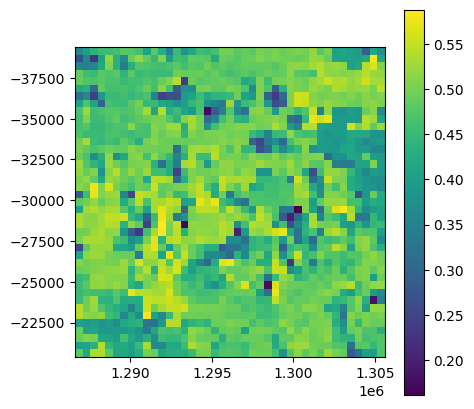

In [8]:
with rasterio.open('output/vnp13a1_evi.tif') as src:
    grid2 = src.read(1, masked=True)
    fig, ax = plt.subplots(figsize=(5,5))
    # color bar
    fig.colorbar(ax.imshow(grid2*scale), ax=ax)
    rasterio.plot.show(grid2, transform=src.transform, ax=ax)

The above GeoTIFF file can now be imported into a GIS system for further analysis. If you want to quality filter this dataset, please refer to [this tutorial](https://github.com/ornldaac/modis_restservice_qc_filter_Python/blob/master/modis_restservice_qc_filter_Python.ipynb) for further details.